In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
from IPython.display import clear_output

from kpmb_weather import find_stations, get_id

delta_elev_m = 100 # maximum allowed difference between lake and weather station elevation

delta_elev_ft = delta_elev_m*3.28084 # 100 metres converted to feet

nlakes = 100

volume = 'Data'
volume = 'My Passport for Mac'
dftopN = pd.read_csv(f'/Volumes/{volume}/IceModels/topUSlakes.csv')

dfstations = pd.read_csv(f'/Volumes/{volume}/IceModels/topUSlakes_weather_stations.csv')

Look for and remove stations that do not contain any temperature information

In [14]:
for i,c in enumerate(dfstations.GHCND_ID.unique()):
    clear_output(wait=True)
    print(f"{i+1:4d}/{len(dfstations.GHCND_ID.unique())}")
    try:
        df_ = pd.read_csv(f'/Volumes/{volume}/WeatherData/NOAA/csv/{c}.csv')
        # look for stations that are missing temperature data
        if len(df_.dropna(how='all',axis=1).columns.intersection(['TMIN','TMAX','TAVG']))==0:
            dfstations.loc[dfstations.GHCND_ID==c,'temperature'] = False
        else:
            dfstations.loc[dfstations.GHCND_ID==c,'temperature'] = True
    except:
        continue

3012/3012


In [26]:
from importlib import reload
import kpmb_weather
reload(kpmb_weather)
from kpmb_weather import find_stations,get_id

In [16]:
dfstations_temp = dfstations[dfstations.temperature==True]
#dfstations_temp

Build weather time series based on availability of TMINMAX (i.e., TMIN, TMAX and TAVG data).
- **NEW FEB 10 2022** All data in a given row is from the same weather station.

In [28]:
dfworking = pd.DataFrame()
#dfworking_station = pd.DataFrame()

# run through list of lakes
for i,row in dftopN.iterrows():

    #if row.lakecode != "LR1":
    #    continue
    clear_output(wait=True)
    print(f"{i+1:2d}/100 - {row.lakecode}")
    lat,lon = row.lat, row.lon

    elevation = row.Elevation *3.28084 # convert to feet since stations are in feet

    start_date = f'1 January {row.start_date}'
    end_date = f'31 December {row.end_date}'

    # finds stations within 50 km
    stations,_,distances = find_stations(lat,lon,dfstations_temp,
                                         verbose=False,
                      dist=50,elev=elevation, d_elev=delta_elev_ft,
                      start_date=start_date,end_date=end_date)
    # stations is a dictionary of {station_number: [list of timestamps]}
    
    # get list of station ID from closest to furthest
    other_stations = get_id(lat,lon, dfstations_temp, dist=50,elev=elevation,
                            d_elev=delta_elev_ft,getid='GHCND_ID')

    # start to build up time series
    df_lakecode = pd.DataFrame(index=pd.date_range(start_date,end_date))
    
    # cycles from most to least coverage (but no specific mention of TMIN or TMAX) 
    #     so could be most SNOW coverage perhaps...
    for key,value in stations.items():
        # key is station number NCDCSTN_ID
        # value is list of dates
        
        #d1min = min(d1).strftime('%Y-%m-%d')
        #d1max = max(d1).strftime('%Y-%m-%d')
        ghcnd_id = dfstations_temp[dfstations_temp.NCDCSTN_ID==key].GHCND_ID.dropna().unique()
        
        
        for ghcnd in ghcnd_id:
            # read in data from file (all data gets read in)
            filename = f'/Volumes/{volume}/WeatherData/NOAA/csv/{ghcnd}.csv'
            try:
                dfoo = pd.read_csv(filename)
            except:
                print('file not found error.')
                continue
            dfoo = dfoo.set_index('DATE')
            dfoo.index = pd.to_datetime(dfoo.index)
            
            # check quality attributes and remove bad data
            for var in ['TMIN','TMAX','TAVG']:
                dfoo[var] = dfoo[var].astype(float)
                ind_flag = ~dfoo[f'{var}_ATTRIBUTES'].astype(str).str.split(',').str[1].astype(str).str.strip().isin(['','nan'])
                dfoo.loc[ind_flag,var] = np.nan
            
            dfoo['TMINMAX'] = (dfoo['TMIN'] + dfoo['TMAX'])/2.
            ind = dfoo.TMINMAX.isnull() & ~dfoo.TAVG.isnull()
            dfoo.loc[ind,'TMINMAX'] = dfoo.loc[ind,'TAVG'].copy()
            
            station = dfoo.STATION.drop_duplicates().tolist()[0]
            # fills in blanks with data from other stations
            
            if df_lakecode.shape[1]==0:
                df_lakecode = df_lakecode.merge(dfoo,left_index=True,right_index=True, how='left')
                #df_station_record = df_lakecode.astype(str).copy()
                #df_station_record[df_station_record!='nan'] = station
            
                df_lakecode['TMINMAX'] = (df_lakecode['TMIN']+ df_lakecode['TMAX'])/2.
                ind = df_lakecode.TMINMAX.isnull() & ~df_lakecode.TAVG.isnull()
                df_lakecode.loc[ind,'TMINMAX'] = df_lakecode.loc[ind,'TAVG'].copy()
            
            else:
                # [old version]
                # df_lakecode= df_lakecode.fillna(dfoo)
                
                # fill in where TMINMAX is null
                ind_rows = df_lakecode.TMINMAX.isnull() & ~dfoo.TMINMAX.isnull()
            
                df_lakecode.loc[ind_rows,:] = dfoo.loc[ind_rows,:].copy()
                
                #ind_new = df_lakecode.isnull() & ~dfoo.isnull() #& (df_station_record=='nan')
                #df_station_record[ind_new] = station
                #
    # now fillna using other_stations    
    
    for ghcnd in other_stations:
        #print(ghcnd)
        filename = f'/Volumes/{volume}/WeatherData/NOAA/csv/{ghcnd}.csv'
        try:
            dfoo = pd.read_csv(filename,low_memory=False)
        
        except:
            print(ghcnd)
            print('file not found error.')
            continue
        if len(dfoo)==0:
            continue
            
        #print(ghcnd, dfoo.DATE.min(),dfoo.DATE.max())
        dfoo = dfoo.set_index('DATE')
        dfoo.index = pd.to_datetime(dfoo.index)
        
        # check quality attributes and remove bad data
        for var in ['TMIN','TMAX','TAVG']:
            dfoo[var] = dfoo[var].astype(float)
            ind_flag = ~dfoo[f'{var}_ATTRIBUTES'].astype(str).str.split(',').str[1].astype(str).str.strip().isin(['','nan'])
            dfoo.loc[ind_flag,var] = np.nan

        dfoo['TMINMAX'] = (dfoo['TMIN'] + dfoo['TMAX'])/2.
        ind = dfoo.TMINMAX.isnull() & ~dfoo.TAVG.isnull()
        dfoo.loc[ind,'TMINMAX'] = dfoo.loc[ind,'TAVG'].copy()
        
        #station = dfoo.STATION.drop_duplicates().tolist()[0]
        if df_lakecode.shape[1]==0:
            df_lakecode = df_lakecode.merge(dfoo,left_index=True,right_index=True, how='left')
            
            df_lakecode['TMINMAX'] = (df_lakecode['TMIN']+ df_lakecode['TMAX'])/2.
            ind = df_lakecode.TMINMAX.isnull() & ~df_lakecode.TAVG.isnull()
            df_lakecode.loc[ind,'TMINMAX'] = df_lakecode.loc[ind,'TAVG'].copy()
            
            #df_station_record = df_lakecode.astype(str).copy()
            #df_station_record[df_station_record!='nan'] = station
        else:
            # [old version] filling blanks with data from different stations; 
            # so SNOW and TMINMAX for example may be from
            #     different stations... (record station!)
            # df_lakecode= df_lakecode.fillna(dfoo)
            
            # consistently fill in data only if TMINMAX is missing
            ind_rows = df_lakecode.TMINMAX.isnull() & ~dfoo.TMINMAX.isnull()
            
            df_lakecode.loc[ind_rows,:] = dfoo.loc[ind_rows,:].copy()
            
    #df_station_record['lakecode']= row.lakecode
    #df_station_record['lake'] = row.lake
    #df_station_record = df_station_record.reset_index().rename({'index':'DATE'},axis=1)
    #dfworking_station = dfworking_station.append(df_station_record,ignore_index=True)
    
    df_lakecode['lakecode']= row.lakecode
    df_lakecode['lake'] = row.lake
    df_lakecode = df_lakecode.reset_index().rename({'index':'DATE'},axis=1)
    dfworking = dfworking.append(df_lakecode,ignore_index=True)

100/100 - xKB1987


In [23]:
#dfworking.set_index('DATE').SNOW.plot()

In [ ]:
#df00 = pd.read_csv('/Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300379.csv')

In [ ]:
#df00[df00.DATE=='1932-01-01'].dropna(how='all',axis=1)

In [ ]:
#df_lakecode[~df_lakecode.TMINMAX.isnull()].set_index('DATE').STATION.unique()#['TMINMAX'].plot()
#df_lakecode[df_lakecode.STATION=='USC00302780']

In [ ]:
#dfstations[dfstations.GHCND_ID.isin(df_lakecode.dropna(how='all',axis=0).dropna(how='all',axis=1).STATION.unique())][['NCDCSTN_ID','GHCND_ID']].drop_duplicates()

In [ ]:
#df_lakecode[df_lakecode.STATION.isin(['USW00014771','USC00300379'])]

In [ ]:
#df_station_record[(df_station_record['TMAX']!= df_station_record['TMIN'])]

In [4]:
#dfstations[dfstations.NCDCSTN_ID==20021025]

### QA/QC

List of variables:

- (AWDR : wind direction)
- AWND (m/s) : average daily wind speed
- PRCP (mm): precipitation
- SNOW (mm): snow
- SNWD (mm): snow depth
- TAVG (C): average temperature?
- THIC (mm): thickness of ice on water
- TMAX (C): maximum temperature
- TMIN (C): minimum temperature
- TOBS (C): temperature at the time of observation
- TSUN (minutes): daily total sunshine

Check attribute columns (Meas,Qual,Source,Time) and remove data with a non-blank Qual flag 

In [29]:
dfresult = dfworking.copy()
for c in dfworking.columns:
    if 'ATTRIBUTES' in c:
        if len(dfworking[c].dropna())>0:
            new_c = f"{c}_QUALITY"
            print(new_c)
            
            # Add new columns containing data quality flags only
            dfresult[new_c] = dfworking[c].dropna().str.split(',').str[1]
            dfresult[new_c] = dfresult[new_c].str.strip().replace('',np.nan)
            
            # Remove flagged data from table
            ind = ~dfresult[new_c].isnull()
            dfresult.loc[ind,c.replace('_ATTRIBUTES','')] = np.nan
            

AWND_ATTRIBUTES_QUALITY
PRCP_ATTRIBUTES_QUALITY
SNOW_ATTRIBUTES_QUALITY
SNWD_ATTRIBUTES_QUALITY
TAVG_ATTRIBUTES_QUALITY
TMAX_ATTRIBUTES_QUALITY
TMIN_ATTRIBUTES_QUALITY
TOBS_ATTRIBUTES_QUALITY
TSUN_ATTRIBUTES_QUALITY


Convert columns to float dtype, date and sort by lakecode and date

In [30]:
for c in dfresult.columns:
    try:
        dfresult[c] = dfresult[c].astype(float)
    except:
        print(c)

dfresult.DATE = pd.to_datetime(dfresult.DATE)

dfresult = dfresult.sort_values(['lakecode','DATE'])

DATE
STATION
AWND_ATTRIBUTES
PRCP_ATTRIBUTES
SNOW_ATTRIBUTES
SNWD_ATTRIBUTES
TAVG_ATTRIBUTES
TMAX_ATTRIBUTES
TMIN_ATTRIBUTES
TOBS_ATTRIBUTES
TSUN_ATTRIBUTES
lakecode
lake
AWND_ATTRIBUTES_QUALITY
PRCP_ATTRIBUTES_QUALITY
SNOW_ATTRIBUTES_QUALITY
SNWD_ATTRIBUTES_QUALITY
TAVG_ATTRIBUTES_QUALITY
TMAX_ATTRIBUTES_QUALITY
TMIN_ATTRIBUTES_QUALITY
TOBS_ATTRIBUTES_QUALITY
TSUN_ATTRIBUTES_QUALITY


### Calculate daily average temperatures

$$T_{\rm avg} = \frac{T_{\rm min}+T_{\rm max}}{2}$$


- fill in missing (or low quality) data with TAVG, if the value exists

In [31]:
dfresult['TMINMAX'] = (dfresult.TMIN + dfresult.TMAX)/2.

# confirm that average is null where it should be
ind = dfresult.TMIN.isnull() | dfresult.TMAX.isnull() 

display(dfresult.loc[ind,'TMINMAX'].dropna())

dfresult.loc[ind,'TMINMAX'] = np.nan

# fill in blanks with TAVG if it exists

ind = dfresult.TMINMAX.isnull() & ~dfresult.TAVG.isnull()

dfresult.loc[ind,'TMINMAX'] = dfresult.loc[ind,'TAVG']


Series([], Name: TMINMAX, dtype: float64)

## Snow and precipitation

1. How are snow and precipitation related?
- it seems that they are independent
- PRCP is "rain, melted snow"


2. Check that it is cold enough for snow.


<AxesSubplot:xlabel='PRCP'>

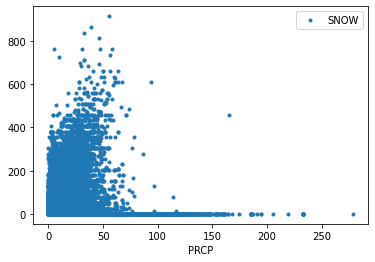

In [32]:
dfresult.plot(x='PRCP',y='SNOW',ls='none',marker='.')

Text(0.5, 0, 'Amount of snow fall (mm)')

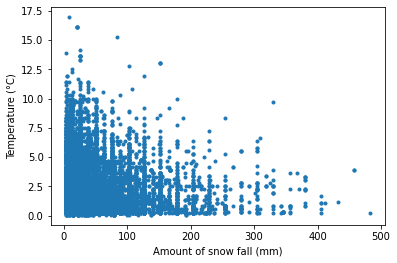

In [40]:
ind = (dfresult.SNOW>0) & (dfresult.TMINMAX>0)

x = dfresult[ind].SNOW
y = dfresult[ind].TMINMAX
plt.plot(x,y, ls='none',marker='.')
plt.ylabel('Temperature (\N{DEGREE SIGN}C)')
plt.xlabel('Amount of snow fall (mm)')

In [41]:
#ind = (dfresult.TMINMAX>15) & (dfresult.SNOW > 0)
#dfresult[ind].dropna(how='all',axis=1)

In [42]:
dfresult.describe()

,AWDR,AWDR_ATTRIBUTES,AWND,PRCP,SNOW,SNWD,TAVG,THIC,THIC_ATTRIBUTES,TMAX,TMIN,TOBS,TSUN,TMINMAX
count,0.0,0.0,161470.000000,2.615453e+06,2.332657e+06,2.000024e+06,64765.000000,0.0,0.0,2.675926e+06,2.676166e+06,2.161190e+06,135777.000000,2.674968e+06
mean,NaN,NaN,3.981785,2.289109e+00,4.469438e+00,6.069330e+01,7.698178,NaN,NaN,1.235803e+01,6.523249e-01,6.408547e+00,384.926468,6.506743e+00
std,NaN,NaN,1.679474,6.595064e+00,2.116437e+01,1.384310e+02,12.313990,NaN,NaN,1.282705e+01,1.217317e+01,1.286101e+01,299.124963,1.227200e+01
min,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-32.800000,NaN,NaN,-3.560000e+01,-5.110000e+01,-5.000000e+01,0.000000,-4.140000e+01
25%,NaN,NaN,2.800000,0.000000e+00,0.000000e+00,0.000000e+00,-1.100000,NaN,NaN,1.700000e+00,-7.200000e+00,-2.200000e+00,48.000000,-2.500000e+00
50%,NaN,NaN,3.800000,0.000000e+00,0.000000e+00,0.000000e+00,8.900000,NaN,NaN,1.330000e+01,1.700000e+00,6.700000e+00,411.000000,7.500000e+00
75%,NaN,NaN,5.100000,1.000000e+00,0.000000e+00,2.500000e+01,18.300000,NaN,NaN,2.390000e+01,1.060000e+01,1.670000e+01,643.000000,1.695000e+01
max,NaN,NaN,13.900000,2.781000e+02,9.140000e+02,2.134000e+03,32.200000,NaN,NaN,4.440000e+01,3.220000e+01,4.220000e+01,1402.000000,3.640000e+01


Fill in blanks. Interpolate over blank days, up to 3 consecutive NaN.

- should be OK for temperature, snow depth
- precipitation and snow may not make sense...

In [43]:
dfresult_filled = dfresult.copy()

for name,group in dfresult[['DATE','STATION','lakecode','lake','TMINMAX','SNOW','PRCP','SNWD','TSUN']].groupby('lakecode'):
    clear_output(wait=True)
    print(name)
    for c in ['TMINMAX',
              #'SNOW','PRCP', # can't justify interpolating snow and precipitation
              'SNWD', # snow depth would make sense to interpolate between two days.
              'TSUN' # number of sun minutes can also be justified for interpolation
             ]:
        ts = group[c].astype(float)
        ts_filled = ts.interpolate(method='linear',limit=3, limit_area='inside')
        ind = (ts!=ts_filled) & (~ts_filled.isnull())
        print(c,ind.sum())
        dfresult_filled.loc[group.index,c] = ts_filled

xKB1987
TMINMAX 0
SNWD 73
TSUN 310


In [44]:
#dfresult[dfresult.lakecode=='DMR2'].set_index('DATE').tail(8380).head(10).dropna(how='all',axis=1)

These lakes have incomplete daily temperature records (1960 - now )

In [45]:
for name,group in dfresult_filled[dfresult_filled.TMINMAX.isnull() & (dfresult_filled.DATE.dt.year>=1960)].groupby('lakecode'):
    print(name, group.lake.drop_duplicates().to_list()[0], group.DATE.dt.year.unique())

JJM33 bayfield [2009]
KMS18 schroon [1968 1980 1985]
xKB0555 floyd [1976 1992 1993 1994 1996]


Check completion of columns

In [46]:
#ind = dfresult_filled.TMINMAX.isnull() #& ~dfresult_filled.TOBS.isnull()
#display(dfresult_filled[ind])

### Save continuous time series
- changed to "extra" weather in filename

In [47]:
dfresult_filled.to_csv(f'/Volumes/{volume}/IceModels/top{nlakes}_extra_weather_all_deltaElev_{delta_elev_m}m.csv',index=False)


___
### QA/QC. Check weather station elevation vs lake elevation

In [36]:
dfresult = pd.DataFrame()

for stn,group in dfresult_filled.groupby('STATION'):
    dfmerge = group.copy()
    
    dfstn = dfstations.loc[dfstations.GHCND_ID==stn,['BEGIN_DATE','END_DATE','GHCND_ID','ELEV_GROUND','ELEV_GROUND_UNIT']]

    # backfill/forward fill if data is missing for given years, assuming elevation hasn't changed
    dfstn = dfstn.fillna(method='bfill').fillna(method='ffill')
    
    dfstn.BEGIN_DATE = dfstn.BEGIN_DATE.replace(10101,17000101)
    dfstn.END_DATE = dfstn.END_DATE.replace(99991231,21001231)
    
    newindex = pd.to_datetime(dfstn.set_index('BEGIN_DATE').index.tolist(),format='%Y%m%d')
    dfstn.index = newindex
    
    # create a continuous time series
    dfstn_new = dfstn[~dfstn.index.duplicated(keep='first')]
    dfstn_new = dfstn_new.resample('D').ffill()
    # find where elevation of station changes
    dfstn_new = dfstn_new[dfstn_new.ELEV_GROUND.diff() != 0]
    # redefine END_DATE based on when elevation changes (i.e., day before next BEGIN_DATE)
    dfstn_new['END_DATE'] = dfstn_new.index #-pd.to_timedelta('1 day')
    dfstn_new['END_DATE'] = dfstn_new['END_DATE'].shift(-1).dt.strftime('%Y%m%d')
    dfstn_new = dfstn_new.reset_index(drop=True)
    
    # make sure all dates before and after are included in case the station summary file is missing dates
    dfstn_new.iloc[0,0] = 10101
    dfstn_new.iloc[-1,1] = 99991231
    dfstn = dfstn_new.copy()
    
    if len(dfstn)==1:
        dfoo = group.reset_index().merge(dfstn,left_on='STATION',right_on='GHCND_ID').set_index('index')
    elif len(dfstn)==0:
        print('missing')
        break
    else:
        df_elev = pd.DataFrame()
        for i,row in dfstn.iterrows():
            if row.BEGIN_DATE==10101:
                #display(dfstn)
                begin_date = pd.to_datetime('1700-01-01')
            else:
                begin_date = pd.to_datetime(row.BEGIN_DATE, format='%Y%m%d')
            if row.END_DATE==99991231:
                end_date = pd.to_datetime('2100-12-31')
            else:
                # subtract one day so inclusive between statement below works as expected
                end_date = pd.to_datetime(row.END_DATE, format='%Y%m%d') - pd.to_timedelta('1 day')
            #print(begin_date,end_date)
            ind = group.DATE.between(begin_date, end_date, inclusive='both')
            solution_ =  group[ind].reset_index().merge(row.to_frame().T, left_on='STATION',right_on='GHCND_ID',how='left').set_index('index')
            df_elev = df_elev.append(solution_[row.index].dropna())
            #if len(df_elev) == len(group):
            #    break
                
        try:
            assert len(df_elev) == len(group)
        except AssertionError:
            print('Assertion Error.')
            display(group.loc[[j for j in group.index if j not in df_elev.index]])
            break

        dfoo = group.merge(df_elev, left_index=True, right_index=True,how='left')
    dfresult = dfresult.append(dfoo)

# finally append missing station rows
dfresult = dfresult.append(dfresult_filled[dfresult_filled.STATION.isnull()])
        

In [37]:
dfresult2 = dfresult.merge(dftopN.loc[:,['lakecode',
                                              'Elevation']].drop_duplicates().rename({'Elevation':'Lake_elevation'},axis=1),
               left_on='lakecode',right_on='lakecode',validate='many_to_one',how='left')

dfresult2['Elevation_difference'] = dfresult2.ELEV_GROUND/3.28084 - dfresult2.Lake_elevation

dfresult2[np.abs(dfresult2.Elevation_difference) >100].drop_duplicates(['STATION','lakecode'])

,DATE,STATION,TAVG,TMAX,TMIN,TOBS,lakecode,lake,AWDR,AWND,...,TSUN,TMINMAX,TDIFF,BEGIN_DATE,END_DATE,GHCND_ID,ELEV_GROUND,ELEV_GROUND_UNIT,Lake_elevation,Elevation_difference
104242,2012-02-28,USC00202984,NaN,2.8,-5.6,1.1,RAA3,grand_traverse_bay,NaN,NaN,...,NaN,-1.40,8.4,20041216,99991231,USC00202984,948.0,FEET,176.67,112.280391
1204565,1941-01-01,USC00301492,NaN,-2.2,-5.6,-4.4,KMS5,genegantslet,NaN,NaN,...,NaN,-3.90,3.4,10101,19480501,USC00301492,1050.0,FEET,452.00,-131.96001
1322528,1977-01-29,USC00304207,NaN,-2.2,-24.4,-24.4,KMS9,chautauqua_south,NaN,NaN,...,NaN,-13.30,22.2,19711201,99991231,USC00304207,1250.0,FEET,491.25,-110.250012
1396133,1909-01-01,USC00304555,NaN,-3.9,-20.6,-9.4,KMS17,saranac_lower,NaN,NaN,...,NaN,-12.25,16.7,19090101,19410721,USC00304555,1864.0,FEET,468.00,100.147182
1401196,1898-07-01,USC00304731,NaN,28.9,15.6,NaN,KMS12,mohonk,NaN,NaN,...,NaN,22.25,13.3,18980201,19460701,USC00304731,2300.0,FEET,394.66,306.379978
1469232,2012-11-30,USC00305512,-1.7,4.4,-7.2,-3.9,LR2,cazenovia,NaN,NaN,...,NaN,-1.40,11.6,20110629,99991231,USC00305512,1681.0,FEET,364.00,148.368784
1530198,1901-01-01,USC00308036,NaN,1.1,-11.7,-10.6,KMS18,schroon,NaN,NaN,...,NaN,-5.30,12.8,10101,19120101,USC00308036,1225.0,FEET,246.00,127.379988
1532328,1901-12-01,USC00308036,NaN,3.9,-10.0,NaN,KMS2,brant,NaN,NaN,...,NaN,-3.05,13.9,10101,19120101,USC00308036,1225.0,FEET,242.00,131.379988
1706570,1999-10-01,USC00431580,NaN,17.2,3.9,6.1,KMS2,brant,NaN,NaN,...,NaN,10.55,13.3,19981112,20050728,USC00431580,400.0,FEET,242.00,-120.080004


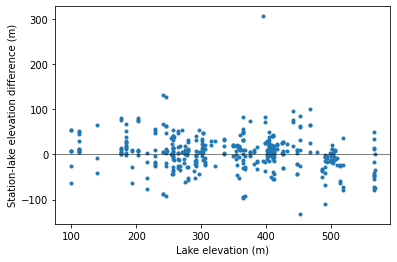

In [40]:
x,y = dfresult2.drop_duplicates(['lakecode','STATION'])[['Lake_elevation', 'ELEV_GROUND']].T.values

ydiff = y/3.28084 - x
fig,ax = plt.subplots()
ax.plot(x,ydiff,marker='.',ls='none')
ax.set_ylabel('Station-lake elevation difference (m)')
ax.set_xlabel('Lake elevation (m)')
#ax.plot([100,700],[100,700],color='k',lw=0.5)
ax.axhline(0,color='k',lw=0.5)